Import Statements

Data set link: https://raw.githubusercontent.com/aaminahmq/Datafiles/refs/heads/main/CS133%20group%20project%20files/diabetes_012_health_indicators_BRFSS2015.csv

In [3]:
#set up

!pip -q install plotly==5.* xgboost==2.* rich==13.* > /dev/null

import os, sys, warnings, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

# sklearn imports for splitting data, scaling, and evaluating models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    f1_score, classification_report, confusion_matrix,
    roc_auc_score
)

# models used in our analysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# for cleaner console formatting
from rich.console import Console
from rich.table import Table

console = Console()

# set default style for plots
sns.set(style="whitegrid", context="notebook")

# set random seed for reproducibility
np.random.seed(42)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading data and pre-processing

In [5]:
#loading data/ preprocessing

# link to the dataset stored on GitHub
RAW_GITHUB_URL = "https://raw.githubusercontent.com/aaminahmq/Datafiles/refs/heads/main/CS133%20group%20project%20files/diabetes_012_health_indicators_BRFSS2015.csv"

# load the dataset into a pandas DataFrame
df = pd.read_csv(RAW_GITHUB_URL)

# target column: 3 classes
# 0 = no diabetes, 1 = prediabetes, 2 = diabetes
df["Diabetes_012"] = df["Diabetes_012"].astype(int)

# create a binary version (0 = healthy, 1 = prediabetes/diabetes)
df["Diabetes_binary"] = (df["Diabetes_012"] > 0).astype(int)

# add easier-to-read labels for general health levels
health_map = {1:"Excellent", 2:"Very Good", 3:"Good", 4:"Fair", 5:"Poor"}
df["GenHlth_Label"] = df["GenHlth"].map(health_map)

# convert the age categories into readable ranges
age_map = {
    1:"18–24", 2:"25–29", 3:"30–34", 4:"35–39", 5:"40–44",
    6:"45–49", 7:"50–54", 8:"55–59", 9:"60–64", 10:"65–69",
    11:"70–74", 12:"75–79", 13:"80+"
}
df["AgeBand"] = df["Age"].map(age_map)

# print basic info so we know the data loaded correctly
console.print(f"[bold green]Dataset Loaded Successfully[/bold green]")
console.print(f"[cyan]Shape:[/cyan] {df.shape}")
console.print(f"[cyan]Columns:[/cyan] {list(df.columns)}")


Dataset Loaded Successfully

Shape: (253680, 25)

Columns: ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 
'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Diabetes_binary', 'GenHlth_Label', 'AgeBand']

Data Checking

In [6]:
#checking data

# check for missing values in each column
missing = df.isnull().sum()
console.print("\n[bold]Missing values per column (should be 0 for this dataset):[/bold]")
for c, v in missing.items():
    if v > 0:
        console.print(f"[red]{c}: {v}[/red]") # highlight if anything is missing
    else:
        console.print(f"{c}: {v}")

# show data types to make sure columns are stored correctly
console.print("\n[bold]dtypes:[/bold]")
console.print(df.dtypes)

# check how balanced the diabetes classes are (0, 1, 2)
class_counts = df["Diabetes_012"].value_counts().sort_index()
console.print("\n[bold]Diabetes_012 distribution (0=no, 1=pre, 2=diab):[/bold]")
console.print(class_counts)


Missing values per column (should be 0 for this dataset):

Diabetes_012: 0

HighBP: 0

HighChol: 0

CholCheck: 0

BMI: 0

Smoker: 0

Stroke: 0

HeartDiseaseorAttack: 0

PhysActivity: 0

Fruits: 0

Veggies: 0

HvyAlcoholConsump: 0

AnyHealthcare: 0

NoDocbcCost: 0

GenHlth: 0

MentHlth: 0

PhysHlth: 0

DiffWalk: 0

Sex: 0

Age: 0

Education: 0

Income: 0

Diabetes_binary: 0

GenHlth_Label: 0

AgeBand: 0

dtypes:

Diabetes_012              int64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
Diabetes_binary           int64
GenHlth_Label            object
AgeBand                  object
dtype: object

Diabetes_012 distribution (0=no, 1=pre, 2=diab):

Diabetes_012
0    213703
1      4631
2     35346
Name: count, dtype: int64

exploratory data analysis for our 5 questions

Q1) Lifestyle factors vs diabetes proportion

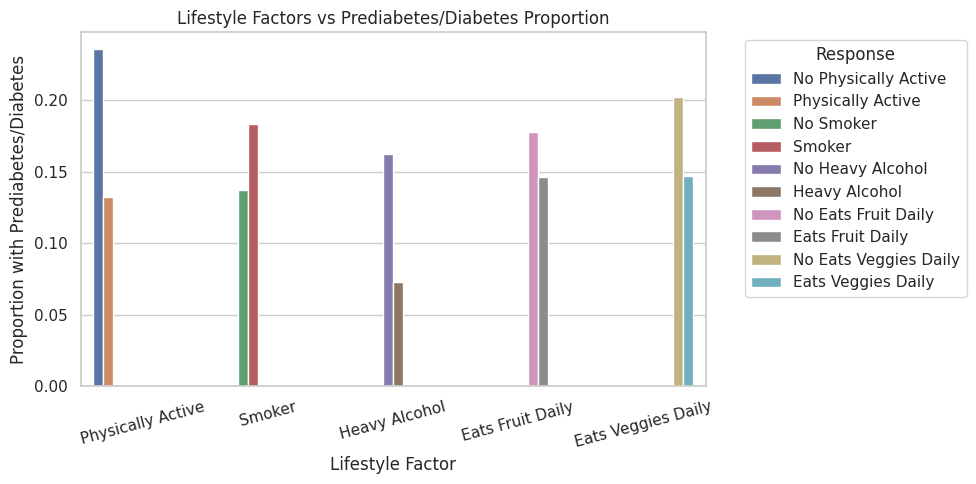

Q2) BMI distributions by diabetes class

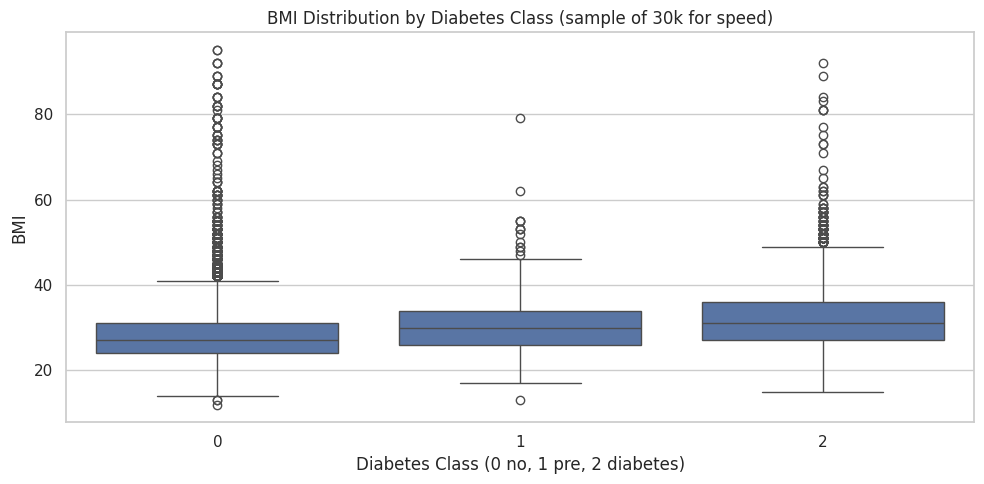

Q3) Mental/Physical health days by diabetes class

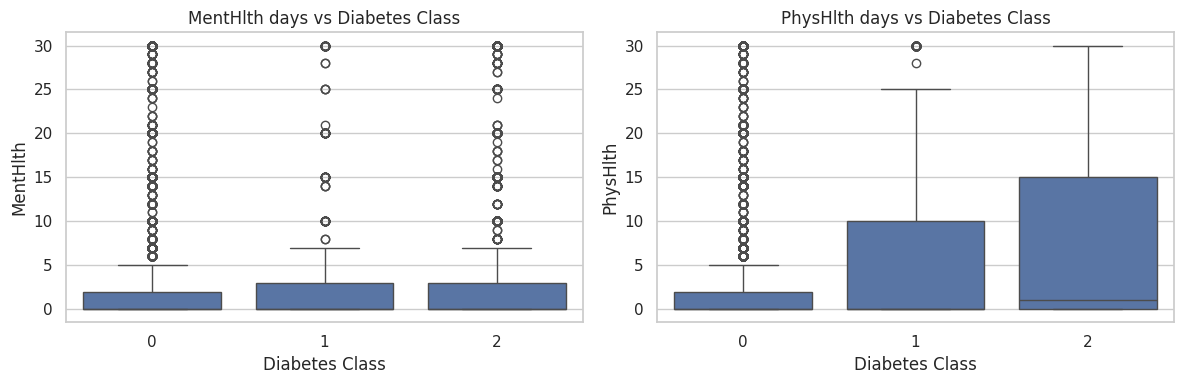

Q4) Income/Education vs diabetes proportion

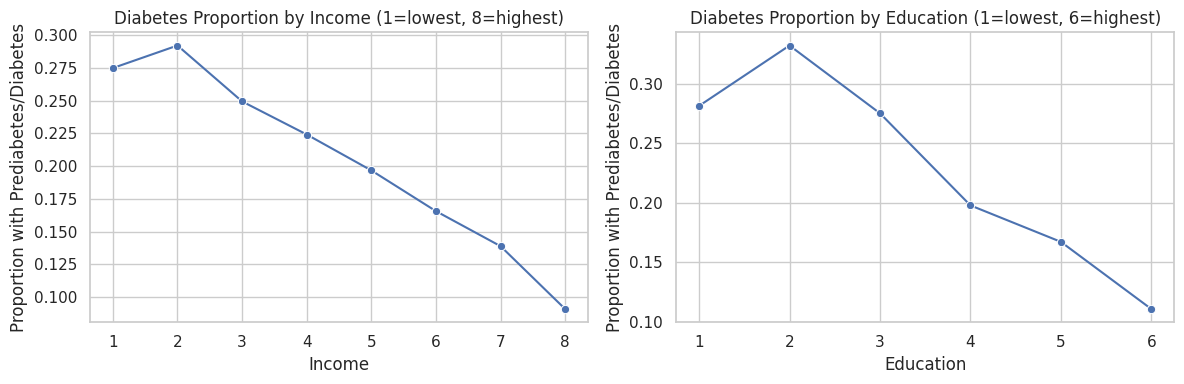

Q5) Healthcare access vs diabetes proportion

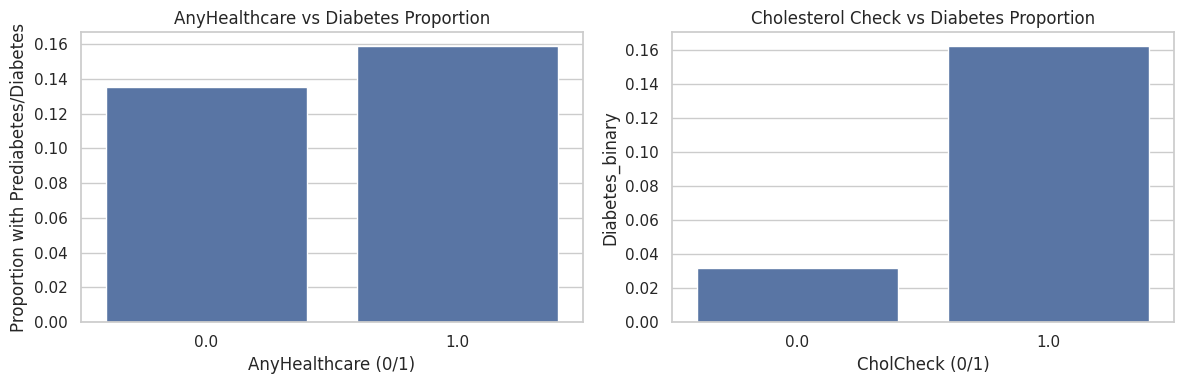

In [ ]:
# Exploratory data analysis

# Q1: Which lifestyle factors (diet, smoking, physical activity) matter most?
console.print("\n[bold underline]Q1) Lifestyle factors vs diabetes proportion[/bold underline]")

q1_long = []
factors = {
    "PhysActivity": "Physically Active",
    "Smoker": "Smoker",
    "HvyAlcoholConsump": "Heavy Alcohol",
    "Fruits": "Eats Fruit Daily",
    "Veggies": "Eats Veggies Daily"
}

# loop through each lifestyle factor and compute diabetes proportion for 0/1 groups
for col, label in factors.items():
    grp = df.groupby(col)["Diabetes_binary"].mean().reset_index()
    grp["response"] = grp[col].map({0: f"No {label}", 1: label})
    grp = grp.rename(columns={"Diabetes_binary": "prop"})
    grp["factor"] = label
    grp = grp[["factor", "response", "prop"]]

    q1_long.append(grp)

# combine into one dataframe for plotting
q1_long = pd.concat(q1_long, ignore_index=True)

# barplot comparing diabetes proportion across all lifestyle factors
plt.figure(figsize=(10, 5))
sns.barplot(data=q1_long, x="factor", y="prop", hue="response")
plt.ylabel("Proportion with Prediabetes/Diabetes")
plt.xlabel("Lifestyle Factor")
plt.title("Lifestyle Factors vs Prediabetes/Diabetes Proportion")
plt.xticks(rotation=15)
plt.legend(title="Response", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Q2: BMI distribution across diabetes classes (0/1/2)
console.print("\n[bold underline]Q2) BMI distributions by diabetes class[/bold underline]")

# sample 30k rows to make the plot faster
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.sample(30000, random_state=42), x="Diabetes_012", y="BMI")
plt.xlabel("Diabetes Class (0 no, 1 pre, 2 diabetes)")
plt.title("BMI Distribution by Diabetes Class (sample of 30k for speed)")

plt.tight_layout()
plt.show()

# Q3: Mental/Physical health days vs diabetes (boxplots)
console.print("\n[bold underline]Q3) Mental/Physical health days by diabetes class[/bold underline]")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# mental health days plot
sns.boxplot(data=df.sample(30000, random_state=42), x="Diabetes_012", y="MentHlth", ax=ax[0])
ax[0].set_title("MentHlth days vs Diabetes Class")
ax[0].set_xlabel("Diabetes Class")

# physical health days plot
sns.boxplot(data=df.sample(30000, random_state=42), x="Diabetes_012", y="PhysHlth", ax=ax[1])
ax[1].set_title("PhysHlth days vs Diabetes Class")
ax[1].set_xlabel("Diabetes Class")

plt.tight_layout()
plt.show()

# Q4: Socioeconomic factors — Income & Education vs diabetes proportion
console.print("\n[bold underline]Q4) Income/Education vs diabetes proportion[/bold underline]")

# compute diabetes proportion for each income and education category
q4_income = df.groupby("Income")["Diabetes_binary"].mean().reset_index()
q4_educ   = df.groupby("Education")["Diabetes_binary"].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# income trend line
sns.lineplot(data=q4_income, x="Income", y="Diabetes_binary", marker="o", ax=ax[0])
ax[0].set_title("Diabetes Proportion by Income (1=lowest, 8=highest)")
ax[0].set_ylabel("Proportion with Prediabetes/Diabetes")

# education trend line
sns.lineplot(data=q4_educ, x="Education", y="Diabetes_binary", marker="o", ax=ax[1])
ax[1].set_title("Diabetes Proportion by Education (1=lowest, 6=highest)")
ax[1].set_ylabel("Proportion with Prediabetes/Diabetes")

plt.tight_layout()
plt.show()

# Q5: Access to care — AnyHealthcare & CholCheck vs diabetes proportion
console.print("\n[bold underline]Q5) Healthcare access vs diabetes proportion[/bold underline]")

# proportion of diabetes for each healthcare indicator
q5_any  = df.groupby("AnyHealthcare")["Diabetes_binary"].mean().reset_index()
q5_chol = df.groupby("CholCheck")["Diabetes_binary"].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# barplot for healthcare coverage
sns.barplot(data=q5_any, x="AnyHealthcare", y="Diabetes_binary", ax=ax[0])
ax[0].set_title("AnyHealthcare vs Diabetes Proportion")
ax[0].set_xlabel("AnyHealthcare (0/1)")
ax[0].set_ylabel("Proportion with Prediabetes/Diabetes")

# barplot for cholesterol check
sns.barplot(data=q5_chol, x="CholCheck", y="Diabetes_binary", ax=ax[1])
ax[1].set_title("Cholesterol Check vs Diabetes Proportion")
ax[1].set_xlabel("CholCheck (0/1)")

plt.tight_layout()
plt.show()


pairwise polynomial regression plot

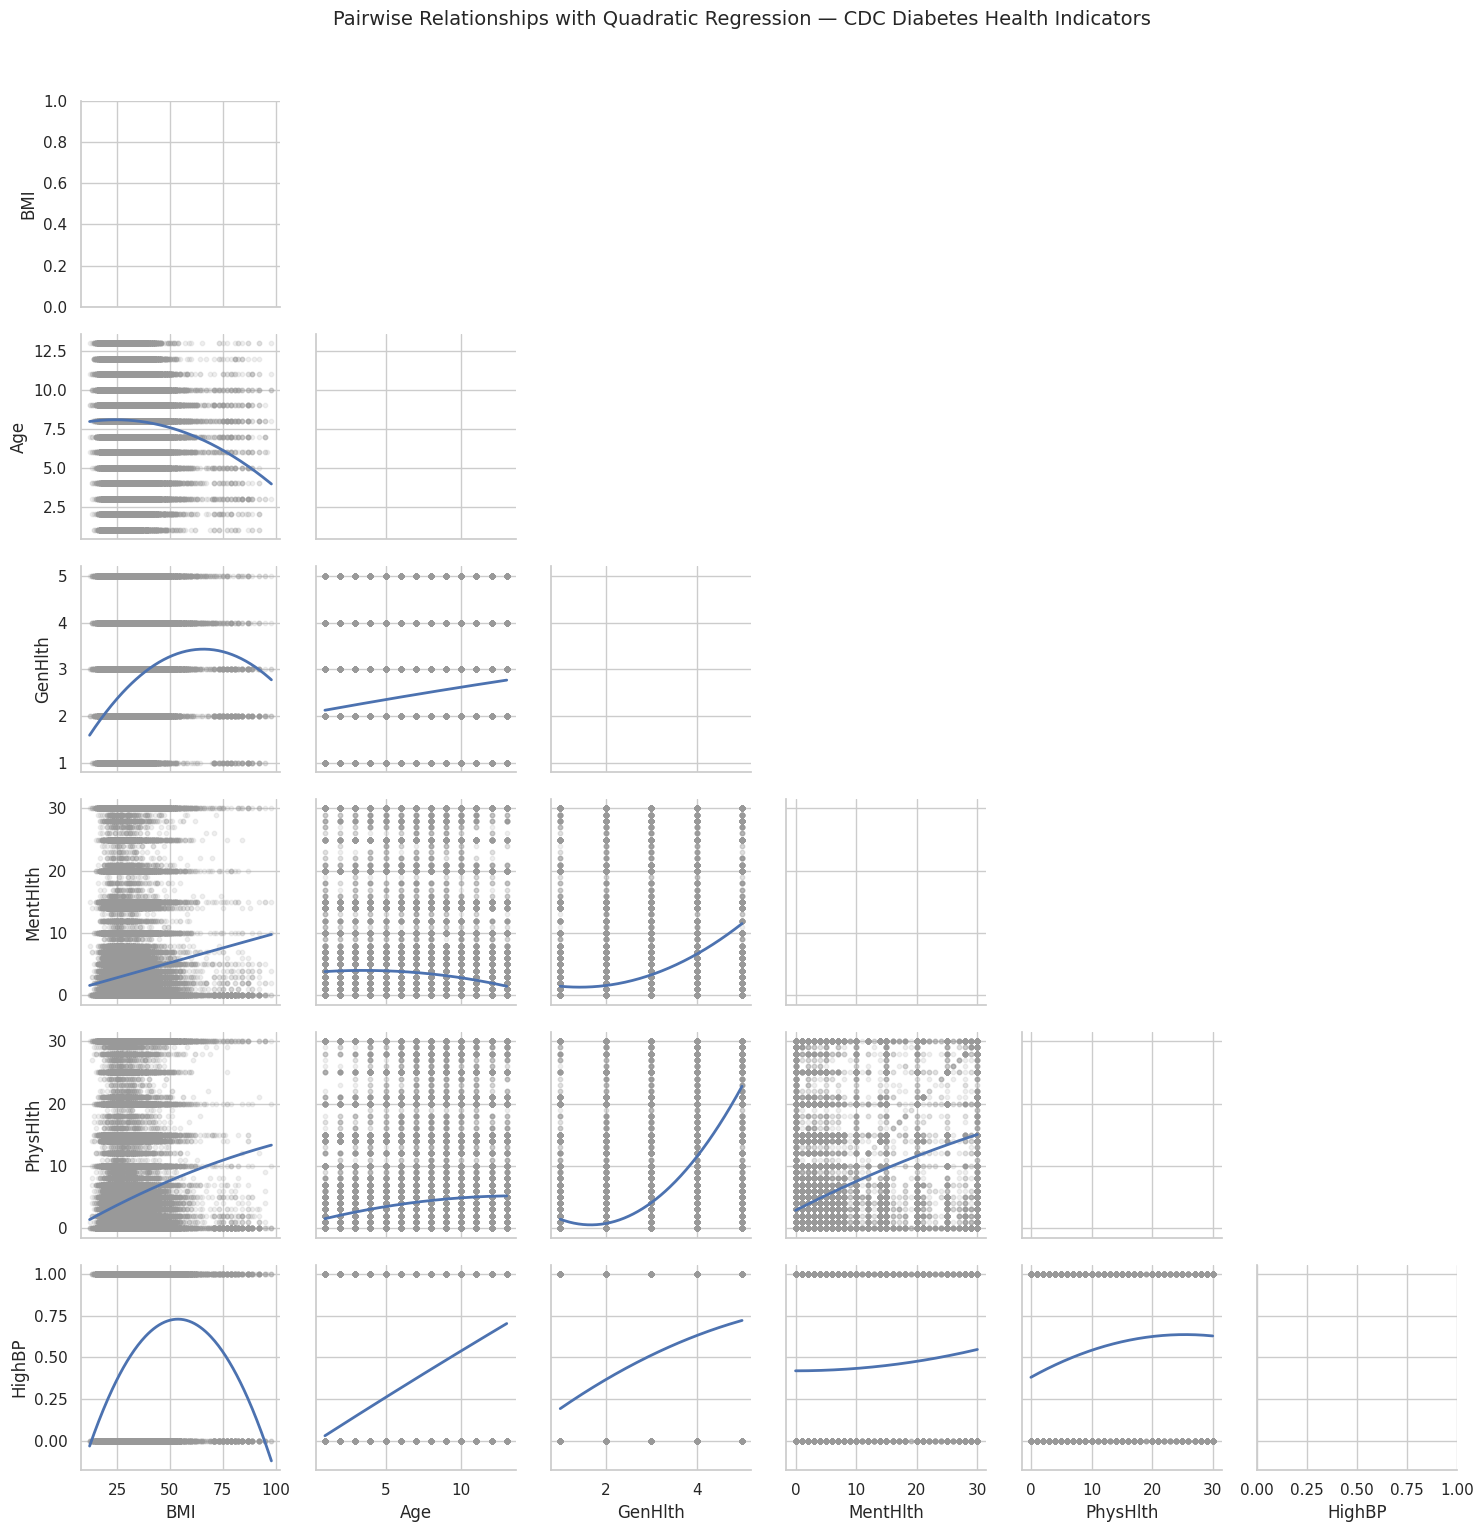

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# selecting the variables we want to compare pairwise
cols = [
    "BMI",
    "Age",
    "GenHlth",
    "MentHlth",
    "PhysHlth",
    "HighBP"
]

# create a smaller dataframe with just those columns
data = df[cols].copy()

sns.set(style="whitegrid")

# PairGrid lets us plot all pairwise variable combinations
g = sns.PairGrid(data, corner=True, diag_sharey=False)

# scatterplots in the lower triangle of the grid
g.map_lower(plt.scatter, s=10, alpha=0.15, color="0.6")

# helper function to draw a polynomial (quadratic) regression line
def draw_poly_reg(x, y, degree=2, line_kwargs=None, **kws):
    m = np.isfinite(x) & np.isfinite(y) # only use valid points
    if m.sum() < degree + 1:
        return
    coeffs = np.polyfit(x[m], y[m], degree) # fit polynomial curve
    xs = np.linspace(x[m].min(), x[m].max(), 200)
    ys = np.polyval(coeffs, xs)
    if line_kwargs is None:
        line_kwargs = dict(linewidth=2)

    plt.plot(xs, ys, **line_kwargs)

# add the polynomial regression lines to each pairwise plot
g.map_lower(draw_poly_reg, degree=2, line_kwargs=dict(linewidth=2))

# overall title for the full grid
g.fig.suptitle(
    "Pairwise Relationships with Quadratic Regression — CDC Diabetes Health Indicators",
    y=1.02, fontsize=14
)

plt.tight_layout()
plt.show()

interactive plot

In [ ]:
# interactive plot element

console.print("\n[bold underline]Interactive Plotly Visualization[/bold underline]")

# define a consistent order for the health categories
genhlth_order = ["Excellent", "Very Good", "Good", "Fair", "Poor"]

# compute the diabetes proportion for each age group and health category
agg = (
    df.groupby(["AgeBand", "GenHlth_Label"], as_index=False)
      .agg(prop=("Diabetes_binary", "mean"), n=("Diabetes_binary", "size"))
)

# custom colors to make the animation easier to read
color_map = {
    "Excellent": "#4CAF50",
    "Very Good": "#2196F3",
    "Good": "#FFC107",
    "Fair": "#FF5722",
    "Poor": "#9C27B0"
}

# create an interactive bar chart that animates across age groups
fig = px.bar(
    agg,
    x="GenHlth_Label",
    y="prop",
    animation_frame="AgeBand", # slider cycles through age groups
    color="GenHlth_Label",
    color_discrete_map=color_map,
    category_orders={"GenHlth_Label": genhlth_order},
    labels={
        "GenHlth_Label": "Self-Reported General Health",
        "prop": "Diabetes/Prediabetes Proportion",
        "AgeBand": "Age Group"
    },
    hover_data={"n": True, "prop": ":.2%"}, # show sample size and percent on hover
    text=agg["prop"].map(lambda v: f"{v:.0%}") # display percent on top of bars
)

# layout settings to clean up the look of the chart
fig.update_layout(
    title="Interactive Diabetes Proportion by General Health Level (Animated by Age Group)",
    yaxis_tickformat=".0%",
    yaxis_title="Proportion with Diabetes or Prediabetes",
    xaxis_title="Self-Reported Health Category",
    bargap=0.15,
    legend_title="Health Level",
    transition={"duration": 400} # smooth animation speed
)

fig.update_traces(textposition="outside", cliponaxis=False)

# show interactive plot in the notebook
fig.show()

# save the interactive visualization as an HTML file
fig.write_html("sugarstats_interactive.html", include_plotlyjs="cdn")

console.print("[green]Interactive Plot saved as:[/green] sugarstats_interactive.html")


Interactive Plotly Visualization

Interactive Plot saved as: sugarstats_interactive.html

In [ ]:
from google.colab import files
files.download("sugarstats_interactive.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Machine Learning Pipeline

                             Cross-Validation Summary (5-fold)                             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model              ┃ CV Acc (mean±std) ┃ CV F1-macro (mean±std) ┃ CV ROC-AUC OvR (mean) ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ LogisticRegression │ 0.689 ± 0.003     │ 0.436 ± 0.002          │ 0.780                 │
│ RandomForest       │ 0.835 ± 0.001     │ 0.424 ± 0.002          │ 0.755                 │
│ XGBoost            │ 0.849 ± 0.002     │ 0.401 ± 0.003          │ 0.778                 │
└────────────────────┴───────────────────┴────────────────────────┴───────────────────────┘

Best by CV macro F1: LogisticRegression

Test Accuracy: 0.690

Test F1-macro: 0.438


Classification Report (Test):
              precision    recall  f1-score   support

           0      0.945     0.705     0.807     42741
           1      0.036     0.187     0.060       926
           2      0.336     0.667     0.447      7069

    accuracy                          0.690     50736
   macro avg      0.439     0.520     0.438     50736
weighted avg      0.843     0.690     0.744     50736



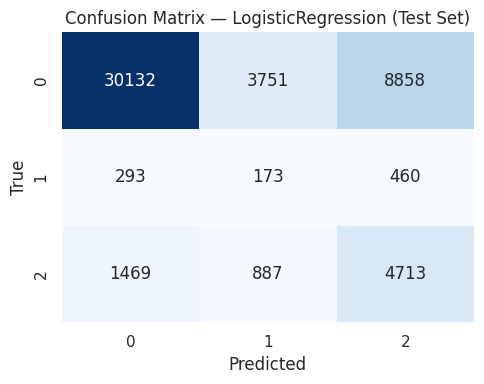

In [7]:
#Machine learning pipeline

TARGET = "Diabetes_012"

# columns we don’t want in the feature matrix (helper or derived variables)
drop_cols = ["Diabetes_binary", "GenHlth_Label", "AgeBand"]

# feature matrix and target vector
X = df.drop(columns=[TARGET] + drop_cols, errors="ignore")
y = df[TARGET].astype(int)

# split into training/testing (80/20) with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# logistic regression pipeline (scaling + classifier)
logreg = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # scaling for stability
    ("clf", LogisticRegression(
        multi_class="ovr", class_weight="balanced", max_iter=1000, n_jobs=None))
])

# random forest classifier
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=4, class_weight="balanced_subsample",
    random_state=42, n_jobs=-1
)

# XGBoost classifier for multiclass
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    learning_rate=0.1,
    n_estimators=400,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# store models in a dictionary for easy looping
models = {
    "LogisticRegression": logreg,
    "RandomForest": rf,
    "XGBoost": xgb
}

# 5-fold stratified CV to preserve class ratios in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# helper to compute macro ROC-AUC for multiclass (OvR) manually
def macro_auc_ovr(estimator, X_val, y_val):
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X_val)
        try:
            return roc_auc_score(y_val, proba, multi_class="ovr")
        except Exception:
            return np.nan
    return np.nan

# run cross-validation for each model
rows = []
for name, est in models.items():
    scores = cross_validate(
        est, X_train, y_train, cv=cv, scoring={
            "accuracy": "accuracy",
            "f1_macro": "f1_macro",
        }, n_jobs=-1, return_estimator=False
    )

    # manually compute AUC per fold
    aucs = []
    for tr_idx, va_idx in cv.split(X_train, y_train):
        Xt, Xv = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        yt, yv = y_train.iloc[tr_idx], y_train.iloc[va_idx]
        est_ = models[name]
        est_.fit(Xt, yt)
        aucs.append(macro_auc_ovr(est_, Xv, yv))

    rows.append({
        "Model": name,
        "CV Acc (mean±std)": f"{scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}",
        "CV F1-macro (mean±std)": f"{scores['test_f1_macro'].mean():.3f} ± {scores['test_f1_macro'].std():.3f}",
        "CV ROC-AUC OvR (mean)": f"{np.nanmean(aucs):.3f}"
    })

# print cross-validation summary table
table = Table(title="Cross-Validation Summary (5-fold)")
table.add_column("Model", style="bold")
table.add_column("CV Acc (mean±std)")
table.add_column("CV F1-macro (mean±std)")
table.add_column("CV ROC-AUC OvR (mean)")
for r in rows:
    table.add_row(r["Model"], r["CV Acc (mean±std)"], r["CV F1-macro (mean±std)"], r["CV ROC-AUC OvR (mean)"])
console.print(table)

# choose best model based on macro F1 (good for multiclass balance)
best_name = max(rows, key=lambda r: float(r["CV F1-macro (mean±std)"].split()[0]))["Model"]
best_est = models[best_name]
console.print(f"\n[bold green]Best by CV macro F1:[/bold green] {best_name}")

# train the best model on the full training data
best_est.fit(X_train, y_train)

# evaluate on the held-out test set
y_pred = best_est.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
test_f1  = f1_score(y_test, y_pred, average="macro")

console.print(f"[bold]Test Accuracy:[/bold] {test_acc:.3f}")
console.print(f"[bold]Test F1-macro:[/bold] {test_f1:.3f}")

# detailed classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, digits=3))

# plot confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[0,1,2], yticklabels=[0,1,2], ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"Confusion Matrix — {best_name} (Test Set)")
plt.tight_layout()
plt.show()


Feature importance

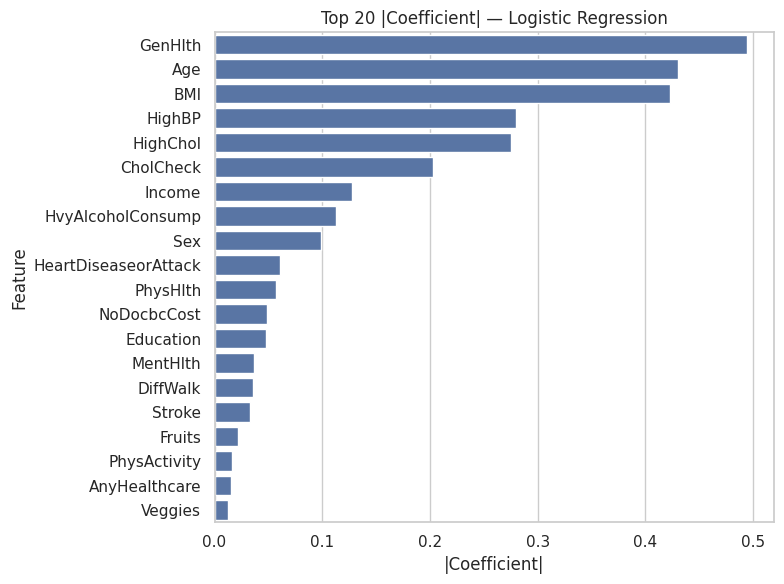

In [8]:
# feature important and best model choice

# if the best model is a tree-based model
if best_name in ("RandomForest", "XGBoost"):
    # check that the model actually supports feature_importances_
    if hasattr(best_est, "feature_importances_"):
        # get feature importances and sort them
        importances = pd.Series(best_est.feature_importances_, index=X.columns).sort_values(ascending=False)
        topk = importances.head(20) # show top 20

        # horizontal bar plot of the most important features
        plt.figure(figsize=(8, 6))
        sns.barplot(x=topk.values, y=topk.index, orient="h")
        plt.title(f"Top 20 Feature Importances — {best_name}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        console.print("[yellow]No feature_importances_ attribute found.[/yellow]")
# if the best model is logistic regression
elif best_name == "LogisticRegression":
    # extract the classifier from the pipeline
    clf = best_est.named_steps["clf"]

    # take average absolute coefficient across the one-vs-rest classes
    coefs = np.mean(np.abs(clf.coef_), axis=0)
    imp = pd.Series(coefs, index=X.columns).sort_values(ascending=False).head(20)

    # plot top 20 coefficients
    plt.figure(figsize=(8, 6))
    sns.barplot(x=imp.values, y=imp.index, orient="h")
    plt.title("Top 20 |Coefficient| — Logistic Regression")
    plt.xlabel("|Coefficient|")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


downloading results (optional to run)

In [9]:
# downloading results

# save the cross-validation summary table
cv_df = pd.DataFrame(rows)
cv_df.to_csv("cv_summary.csv", index=False)
console.print(f"[bold green]Saved CV summary to:[/bold green] {os.path.abspath('cv_summary.csv')}")

# save the confusion matrix from the test set
cm_df = pd.DataFrame(cm, index=[0,1,2], columns=[0,1,2])
cm_df.to_csv("confusion_matrix_test.csv")
console.print(f"[bold green]Saved confusion matrix to:[/bold green] {os.path.abspath('confusion_matrix_test.csv')}")


Saved CV summary to: /content/cv_summary.csv

Saved confusion matrix to: /content/confusion_matrix_test.csv